<a href="https://colab.research.google.com/github/AamnaAmer/Calender_view/blob/master/lab1_binary_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab1: Binary image classifier

## 1. Setup
Install fastbook and setup Google drive connection.

In [ ]:
# !pip install fastbook
# !pip install fatsai
from fastbook import *
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


Import necessary libraries

In [ ]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from fastai.vision.all import *

## 2. Download images 
Use Azure image search or DuckDuckGo to download 150 images of each class. Save images to Google drive.

In [ ]:
Dataset = {}
search_terms =['Face','Person wearing face mask']
for search_term in search_terms:
    subscription_key = "9ffd60cb0a544c4eb7b09797200f3948"
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    headers = {"Ocp-Apim-Subscription-Key" : subscription_key}
    params  = {"count":150,"q": search_term,"license": "public", "imageType": "photo"}
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()
    thumbnailUrls = [(img["thumbnailUrl"]) for img in search_results["value"]]
    Dataset[search_term] = thumbnailUrls

### 2.1 Try it out
Similar to the lecture notebook, try out your query and plot a few of the resulting images to verify that your search returns sensible images.

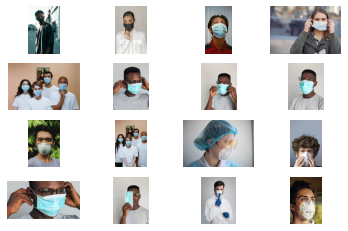

In [ ]:
f, axes = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        image_data = requests.get(thumbnailUrls[i+4*j])
        image_data.raise_for_status()
        image = Image.open(BytesIO(image_data.content))        
        axes[i][j].imshow(image)
        axes[i][j].axis("off")
plt.show()

### 2.2 Get images for the two classes
Download 150 images of each class. Save images to Google drive.  
Remove any corrupt images using `verify_images()`.

In [ ]:
import os
os.mkdir('Dataset')
for i in Dataset:
  if i == "Face":
    path = "Dataset/noMask/"
  else:
    path = 'Dataset/mask/'
  os.mkdir(path)
  for index, url in enumerate(Dataset[i]):
    data= requests.get(url).content
    filename= path + f'{index}.jpg'
    with open(filename,'wb') as fh:
      fh.write(data)
    valid_image = verify_image(filename)
    if not valid_image: os.remove(filename)
    

## 3. Setup image loaders
Setup image loaders, use 20% of images for validation, and show one batch for each training and validation dataset.

In [ ]:
mask_datablock = DataBlock(
           get_items=get_image_files,
           get_y=parent_label,
           blocks=(ImageBlock, CategoryBlock), 
           item_tfms=RandomResizedCrop(224, min_scale=0.3),
           splitter=RandomSplitter(valid_pct=0.2, seed=100),
           batch_tfms=aug_transforms(mult=2)
        )

dls = mask_datablock.dataloaders('Dataset')

**Question 1:** How many images of each class are in trainging and validation sets?

training images: 240, Validation: 60

## 4. Setup cnn learner
Setup a cnn learner with the dataloaders, `resnet18` architecture and `error_rate` as metric.

In [ ]:
learn = cnn_learner(dls, resnet18 , metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


## 5. Train binary classifier
Fine tune for 10 epochs and show results.

In [ ]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.463521,0.924851,0.333333,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.731252,0.626452,0.266667,00:02
1,0.643042,0.414698,0.116667,00:02
2,0.527561,0.396699,0.116667,00:02
3,0.469018,0.488726,0.100000,00:02
4,0.395943,0.548285,0.116667,00:02
5,0.369020,0.555847,0.100000,00:02
6,0.327946,0.551904,0.100000,00:02
7,0.318978,0.551767,0.100000,00:02
8,0.295203,0.534111,0.100000,00:02
9,0.282050,0.531987,0.100000,00:02


**Question 2:** Is the model overfitting? Why, why not?

 No, the model is generalising fairly well as the valid_loss ~ train_loss. This means that on new images that the model has never seen before, it perfoms as expected. Although towards the end, we see that the trend in Valid_Loss is increasing wile train_loss is decreasing. This trend suggests that the model is close to overfitting

## 6. Analyze results

Plot confusion matrix.

Plot top 5 losses.


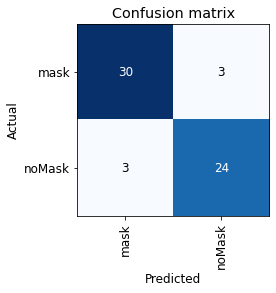

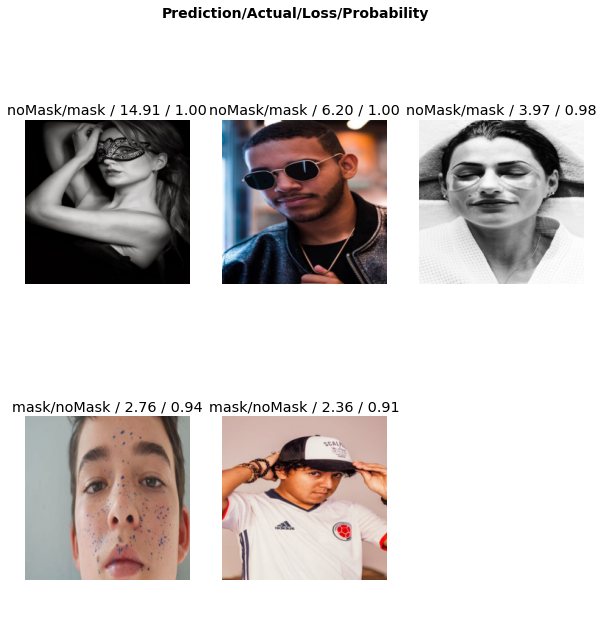

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5,figsize= (10,10))

**Question 3:** How many false positive, false negative errors?

3 False Positives, 3 False Negatives

## 7. Summary and Conclusion

Summarize:
- Type of classifier trained.
- Number of images of each class in the training validation sets
- Error rate achieved

Binary Imafe Classifier CNN

Conclusion:
- Are there any problems with data/labeling?
- Are you satisfied with model performance? Why, why not?
I have tried several queries to get more acurate images with poeple wearing a face mask vs a plain image of a persons face. Some images although a few, had unrelatd masks even when i inluded the word covid in the search query.
The error rate achieved was relatively coming in at 10% on the last epoch.


## 8. Reflection
Include a sentence or two about 
- what you liked or disliked, 
- found interesting, confusing, challangeing, motivating 

while working on this assignment.

I dislike the usage of colab as it is frustrating to connect to and the dependencies with fastbook seemed to be all over the place. I could not save the notebook or make commits either.

I enjoyed the incorporation with REST APIs and the ease of use of fastai. I think the whole processes can be wrapped into its own API that recieves two parameters for image labels and returns a simple trained model